In [1]:
# autoreload your package
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from prob_jsonformer import Jsonformer

print("Loading model and tokenizer...")
model_name = "databricks/dolly-v2-3b"
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    use_cache=True,
    torch_dtype=torch.float16,
    attn_implementation="eager",
).to("cuda:0")
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, use_cache=True)
tokenizer.padding_side = "left"
print("Loaded model and tokenizer")

/media/wassname/SGIronWolf/projects5/2024/prob_jsonformer/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading model and tokenizer...


/media/wassname/SGIronWolf/projects5/2024/prob_jsonformer/.venv/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/media/wassname/SGIronWolf/projects5/2024/prob_jsonformer/.venv/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded model and tokenizer


In [13]:
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.bos_token_id

## Prob dist

- Can LLM's sample from a distribution? http://people.csail.mit.edu/renda/llm-sampling-paper
- Can they forecast events https://arxiv.org/abs/2402.07862

In [26]:
from prob_jsonformer.prob_choice_tree import prob_choice_tree
import pandas as pd

In [135]:
def method0(choices):
    """
    just generate many times
    """

    toks = tokenizer.encode(prompt, return_tensors="pt").to("cuda:0")
    data = []
    for _ in range(100):
        o = model.generate(
            toks,
            do_sample=True,
            max_new_tokens=2,
            temperature=1,
            pad_token_id=tokenizer.pad_token_id
        )
        o = tokenizer.decode(o[0, -2:], skip_special_tokens=True)
        try:
            o = int(o)
        except ValueError:
            print(f"Failed to convert to float `{o}")
            continue
        if str(o) in choices:
            data.append(o)
        else:
            print(f"Generated `{o}` not in choices {choices}")
    d = pd.Series(data).value_counts(normalize=True).to_dict()

    df = pd.DataFrame([d]).T
    df.index = df.index.astype(int)
    df = df.sort_index()
    return df
    # return torch.tensor(data)

def method1(choices):
    """
    Here we try each completion to get the hindsight probability of each choice

    from https://github.com/1rgs/jsonformer/pull/19
    """
    data = {}
    for choice in choices:
        n_option_tokens = tokenizer.encode(f'"{choice}', add_special_tokens=False, return_tensors="pt").shape[1]
        toks = tokenizer.encode(prompt + f"{choice}", return_tensors="pt").to("cuda:0")
        option_tokens = toks[0, -n_option_tokens:]
        o = model.forward(
            toks,
        )
        logits = o.logits[0, -n_option_tokens-1:]

        probabilities = torch.softmax(logits, dim=1)
        option_token_probabilities = probabilities[:-1][torch.arange(probabilities.shape[0]-1), option_tokens]
        option_probability = torch.prod(option_token_probabilities)
        data[choice] = option_probability.item()

    df = pd.DataFrame([data]).T
    df.index = df.index.astype(int)
    df = df.sort_index()
    return df


def method2(choices):
    """
    Useing logit constraints

    https://github.com/1rgs/jsonformer/pull/41
    """
    # TODO

def method3(choices):
    """using my prob choice tree."""
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(
        model.device
    )[0]
    choice_tokens = tokenizer(choices).input_ids
    choice_tokens = [torch.tensor(c) for c in choice_tokens]
    r = prob_choice_tree(model, tokenizer, input_ids, choice_tokens)

    df = pd.DataFrame(r).set_index('choice')
    df['prob'] = df['prob'].astype(float)
    df.index = df.index.astype(int)
    df = df.sort_index()
    return df



prompt = """Q: Please sample a number from the distribution [0, 20]: 
A: """

choices = [str(i) for i in range(21)]

ideal_dist = pd.Series({str(i): 1/21 for i in range(21)})
ideal_dist.index = ideal_dist.index.astype(int)
ideal_dist

0     0.047619
1     0.047619
2     0.047619
3     0.047619
4     0.047619
5     0.047619
6     0.047619
7     0.047619
8     0.047619
9     0.047619
10    0.047619
11    0.047619
12    0.047619
13    0.047619
14    0.047619
15    0.047619
16    0.047619
17    0.047619
18    0.047619
19    0.047619
20    0.047619
dtype: float64

Failed to convert to float `
[
Failed to convert to float `#### 
Failed to convert to float `
[
Failed to convert to float `
Q
Failed to convert to float `
[
Failed to convert to float `
A
Generated `22` not in choices ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
Generated `21` not in choices ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
Failed to convert to float `			
Generated `680` not in choices ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
Generated `23` not in choices ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
Failed to convert to float `
Q
Failed to convert to float `			
Failed to convert to float `
[
Generated `26` not in choices ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12

,0
0,0.115385
1,0.038462
2,0.012821
3,0.025641
4,0.051282
5,0.025641
6,0.051282
7,0.051282
8,0.012821
10,0.128205


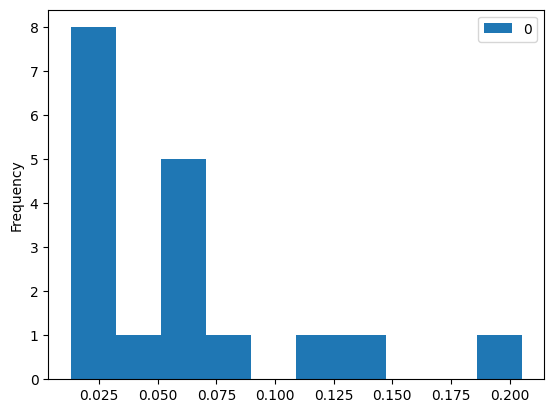

In [145]:
%%time
r0 = method0(choices)
r0.plot.hist()
r0

CPU times: user 489 ms, sys: 0 ns, total: 489 ms
Wall time: 481 ms


,0
0,0.011559
1,0.011833
2,0.015434
3,0.019974
4,0.029968
5,0.050995
6,0.027298
7,0.024841
8,0.028168
9,0.022278


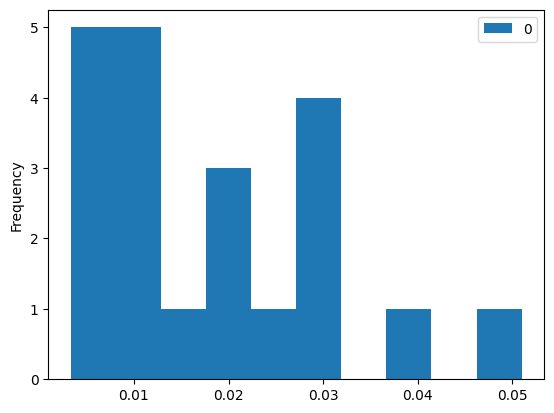

In [146]:
%%time
r1 = method1(choices)
r1.plot.hist()
r1


CPU times: user 57.6 ms, sys: 5.43 ms, total: 63 ms
Wall time: 48.5 ms


,prob
choice,
0,0.00838
1,0.00122
2,0.00229
3,0.00362
4,0.01500
5,0.04450
6,0.03930
7,0.12900
8,0.02750


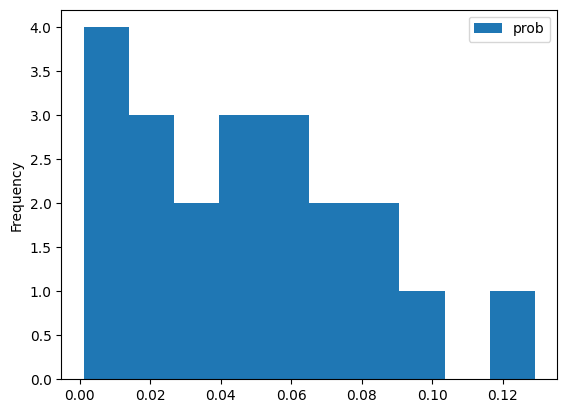

In [147]:
%%time
r3 = method3(choices)
r3.plot.hist()
r3

<Axes: >

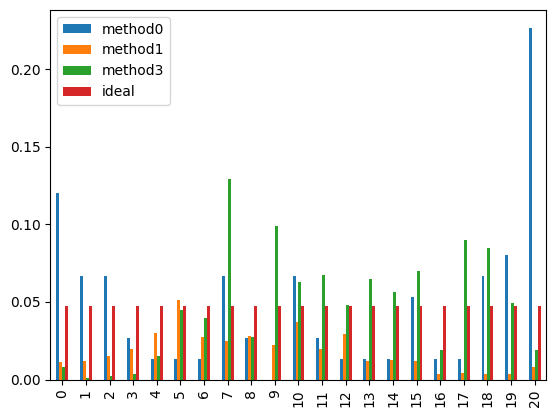

In [139]:
df = pd.concat([r0, r1, r3, ideal_dist], axis=1)
df.columns = ['method0', 'method1', 'method3', 'ideal']
df = df.sort_index().fillna(0)
df.plot.bar()

In [143]:
df_score = df / df['ideal'].values[:, None] - 1
ratios = df_score.iloc[:21, :3]
print('MAE coverage (smaller is better')
ratios.abs().mean()

MAE coverage (smaller is better


method0    0.769524
method1    0.618316
method3    0.592971
dtype: float64

In [144]:
print('MSE coverage (smaller is better)')
ratios.pow(2).mean().pow(0.5)

MSE coverage (smaller is better)


method0    1.056788
method1    0.662643
method3    0.720881
dtype: float64

## Scratch, collapse probs

In [148]:
# def collapse_probs(json_schema, generated_data, keys = []):

#     # get current row
#     schema = json_schema
#     data = generated_data
#     for key in keys[:-1]:
#         print(schema)
#         schema = schema[key]
#         data = data[key]

#     schema_type = schema["type"]

#     if schema_type == "p_enum":
#         k = keys[-1]
#         data[k] = data[k][0]['choice']
#     elif schema_type == "object":
#         k = "properties"
#         for key in schema["properties"]:
#             data["properties"] = collapse_probs(json_schema, generated_data, keys + [key])
    
#     return generated_data


# list(collapse_probs(json_schema, generated_data))